# Import

In [1]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 4.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import optuna
from optuna import Trial
from optuna.samplers import TPESampler

from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report

# EDA

In [3]:
raw = pd.read_csv('predict_yn_special.csv')

In [4]:
df = raw.copy()

## 정리

In [5]:
X = df.copy()
y = df['target']

In [6]:
X = X.drop(['MB_IDX', 'before_audience'], axis=1)

In [7]:
X = X[X.columns[:-11]]

In [8]:
X.head()

,date,before_product_grade,before_special_seat_yn,before_discount_yn,before_discount_way,before_first_yn,before_reserve_count,weekend_yn,night_yn,final_yn,...,before_goal_diff,before_game_result,before_rank,youtube_count,youtube_mean_view,youtube_mean_like,age_group,region,job,favorite_idx
0,2022-02-26,Exciting석,0,0,없음,1,1,1,0,0,...,1,1.0,2,4,2794,158,20,인천광역시,NaN,아길라르
1,2022-02-26,Exciting석,0,0,없음,1,1,1,0,0,...,1,1.0,2,4,2794,158,30,인천광역시,무직,아길라르
2,2022-02-26,Exciting석,0,0,없음,1,1,1,0,0,...,1,1.0,2,4,2794,158,50,인천광역시,서비스업 종사자,이태희
3,2022-03-05,Exciting석,0,0,없음,1,2,1,1,0,...,0,0.5,4,4,1816,97,30,수도권,회사원(사무직/연구직),무고사
4,2022-03-05,Exciting석,0,0,없음,1,3,1,1,0,...,0,0.5,4,4,1816,97,40,인천광역시,공무원,에르난데스


In [9]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17658 entries, 0 to 17657
Data columns (total 22 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   date                    17658 non-null  object 
 1   before_product_grade    17658 non-null  object 
 2   before_special_seat_yn  17658 non-null  int64  
 3   before_discount_yn      17658 non-null  int64  
 4   before_discount_way     17658 non-null  object 
 5   before_first_yn         17658 non-null  int64  
 6   before_reserve_count    17658 non-null  int64  
 7   weekend_yn              17658 non-null  int64  
 8   night_yn                17658 non-null  int64  
 9   final_yn                17658 non-null  int64  
 10  away_team_name          17658 non-null  object 
 11  before_home_goal        17658 non-null  int64  
 12  before_goal_diff        17658 non-null  int64  
 13  before_game_result      17658 non-null  float64
 14  before_rank             17658 non-null

In [10]:
X.isna().sum()

date                         0
before_product_grade         0
before_special_seat_yn       0
before_discount_yn           0
before_discount_way          0
before_first_yn              0
before_reserve_count         0
weekend_yn                   0
night_yn                     0
final_yn                     0
away_team_name               0
before_home_goal             0
before_goal_diff             0
before_game_result           0
before_rank                  0
youtube_count                0
youtube_mean_view            0
youtube_mean_like            0
age_group                    0
region                      29
job                       1929
favorite_idx                 0
dtype: int64

In [11]:
# region과 job에 결측치가 존재함
# region은 인천광역시로 결측치를 일괄적으로 채워주기로 함
# job은 age_group과 관련성이 높을 것이므로 age_group별로 가장 많은 비중을 차지하는 job을 할당해주기로 함

In [12]:
X['region'] = X['region'].fillna('인천광역시')

In [13]:
for i in X['age_group'].unique():
    X.loc[X['age_group'] == i, 'job'] = X.loc[X['age_group'] == i, 'job'].fillna(X[X['age_group'] == i]['job'].value_counts().index[0])

In [14]:
X['date'] = X['date'].str.split('-').str[1].astype(int)
X = X.rename(columns={'date':'month'})

In [15]:
encoder = OrdinalEncoder()

need_encoding = []
for i in X.columns:
    if type(X.loc[0, i]) == str:
        need_encoding.append(i)

encoded = encoder.fit_transform(X[need_encoding])

In [16]:
encoded = encoded.astype(int)

In [17]:
X_encoded = pd.DataFrame(encoded, columns=need_encoding)

In [18]:
X.loc[:, need_encoding] = X_encoded

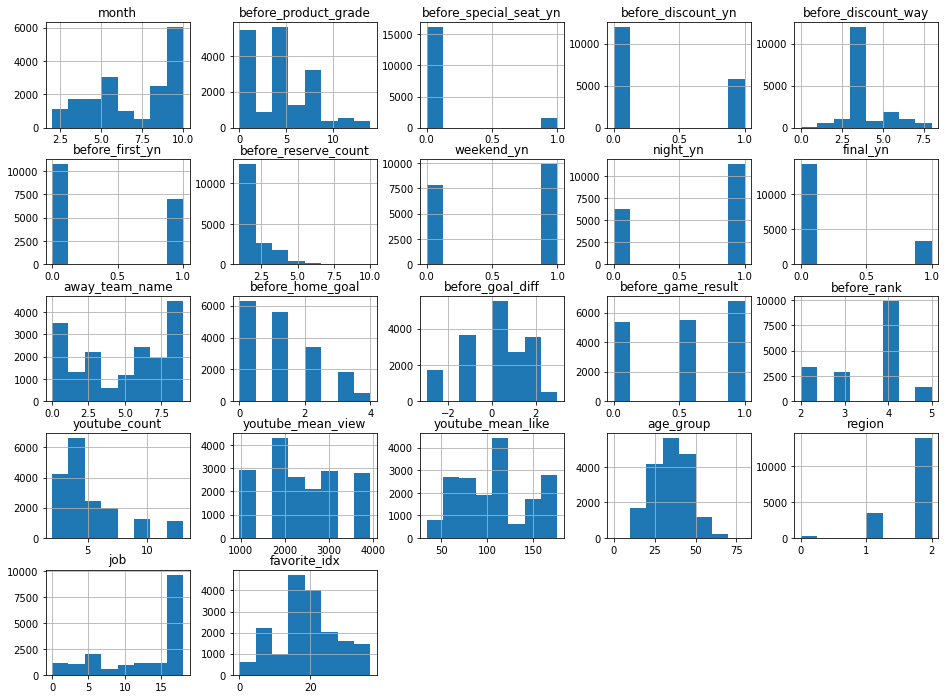

In [19]:
X.hist(figsize=(16,12), bins=8)
plt.show()

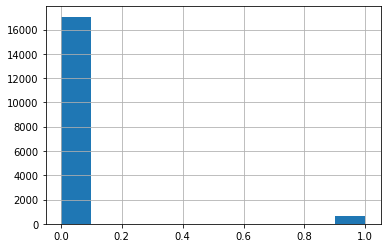

In [20]:
y.hist()
plt.show()

In [21]:
# 타겟 불균형이 심함 > 오버샘플링 SMOTE

# Feature Select

## 1. 직전 경기 결과 및 순위

In [22]:
# 일부 피쳐 드랍
X1 = X.drop(['before_product_grade', 'before_special_seat_yn',
            'before_discount_yn', 'before_discount_way', 'before_first_yn', 'before_reserve_count',
            'youtube_count', 'youtube_mean_view', 'youtube_mean_like'], axis=1)

In [23]:
X1.columns

Index(['month', 'weekend_yn', 'night_yn', 'final_yn', 'away_team_name',
       'before_home_goal', 'before_goal_diff', 'before_game_result',
       'before_rank', 'age_group', 'region', 'job', 'favorite_idx'],
      dtype='object')

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X1, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [25]:
y_train.shape, y_val.shape, y_test.shape

((11300,), (2826,), (3532,))

In [26]:
y_train.value_counts()

0    10914
1      386
Name: target, dtype: int64

In [27]:
# smote = SMOTE(random_state=2)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [28]:
y_train.shape

(11300,)

In [29]:
y_train.value_counts()

0    10914
1      386
Name: target, dtype: int64

In [30]:
score_list1 = []
f1_list1 = []

In [31]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, rfc_prob))
f1_list1.append(f1_score(y_val, rfc_pred))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.615345676260705 

classification_report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2729
           1       0.05      0.01      0.02        97

    accuracy                           0.96      2826
   macro avg       0.51      0.50      0.50      2826
weighted avg       0.93      0.96      0.95      2826



In [32]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, xgc_prob))
f1_list1.append(f1_score(y_val, xgc_pred))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.7215909305549784 

classification_report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2729
           1       0.00      0.00      0.00        97

    accuracy                           0.97      2826
   macro avg       0.48      0.50      0.49      2826
weighted avg       0.93      0.97      0.95      2826



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [33]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list1.append(roc_auc_score(y_val, lgc_prob))
f1_list1.append(f1_score(y_val, lgc_pred))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.7317132139335809 

classification_report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2729
           1       0.42      0.05      0.09        97

    accuracy                           0.96      2826
   macro avg       0.69      0.52      0.54      2826
weighted avg       0.95      0.96      0.95      2826



In [34]:
print('RandomForestClassifier :', score_list1[0])
print('XGBClassifier :', score_list1[1])
print('LGBMClassifier :', score_list1[2])

RandomForestClassifier : 0.615345676260705
XGBClassifier : 0.7215909305549784
LGBMClassifier : 0.7317132139335809


In [35]:
print('RandomForestClassifier :', f1_list1[0])
print('XGBClassifier :', f1_list1[1])
print('LGBMClassifier :', f1_list1[2])

RandomForestClassifier : 0.017094017094017096
XGBClassifier : 0.0
LGBMClassifier : 0.09174311926605505


## 2. 직전 경기 결과 및 순위 + 유튜브

In [36]:
# 일부 피쳐 드랍
X2 = X.drop(['before_product_grade', 'before_special_seat_yn',
            'before_discount_yn', 'before_discount_way', 'before_first_yn', 'before_reserve_count'], axis=1)

In [37]:
X2.columns

Index(['month', 'weekend_yn', 'night_yn', 'final_yn', 'away_team_name',
       'before_home_goal', 'before_goal_diff', 'before_game_result',
       'before_rank', 'youtube_count', 'youtube_mean_view',
       'youtube_mean_like', 'age_group', 'region', 'job', 'favorite_idx'],
      dtype='object')

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X2, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [39]:
# smote = SMOTE(random_state=2)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [40]:
score_list2 = []
f1_list2 = []

In [41]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, rfc_prob))
f1_list2.append(f1_score(y_val, rfc_pred))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.593990472700623 

classification_report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2729
           1       0.05      0.01      0.02        97

    accuracy                           0.96      2826
   macro avg       0.51      0.50      0.50      2826
weighted avg       0.93      0.96      0.95      2826



In [42]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, xgc_prob))
f1_list2.append(f1_score(y_val, xgc_pred))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.730071813624567 

classification_report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2729
           1       0.00      0.00      0.00        97

    accuracy                           0.97      2826
   macro avg       0.48      0.50      0.49      2826
weighted avg       0.93      0.97      0.95      2826



/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.8/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [43]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list2.append(roc_auc_score(y_val, lgc_prob))
f1_list2.append(f1_score(y_val, lgc_pred))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.7019942352661185 

classification_report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2729
           1       0.80      0.04      0.08        97

    accuracy                           0.97      2826
   macro avg       0.88      0.52      0.53      2826
weighted avg       0.96      0.97      0.95      2826



In [44]:
print('RandomForestClassifier :', score_list2[0])
print('XGBClassifier :', score_list2[1])
print('LGBMClassifier :', score_list2[2])

RandomForestClassifier : 0.593990472700623
XGBClassifier : 0.730071813624567
LGBMClassifier : 0.7019942352661185


In [45]:
print('RandomForestClassifier :', f1_list2[0])
print('XGBClassifier :', f1_list2[1])
print('LGBMClassifier :', f1_list2[2])

RandomForestClassifier : 0.017241379310344827
XGBClassifier : 0.0
LGBMClassifier : 0.0784313725490196


## 3. 직전 경기 결과 및 순위 + 직전 예매 특성

In [46]:
# 일부 피쳐 드랍
X3 = X.drop(['youtube_count', 'youtube_mean_view', 'youtube_mean_like'], axis=1)

In [47]:
X3.columns

Index(['month', 'before_product_grade', 'before_special_seat_yn',
       'before_discount_yn', 'before_discount_way', 'before_first_yn',
       'before_reserve_count', 'weekend_yn', 'night_yn', 'final_yn',
       'away_team_name', 'before_home_goal', 'before_goal_diff',
       'before_game_result', 'before_rank', 'age_group', 'region', 'job',
       'favorite_idx'],
      dtype='object')

In [48]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [49]:
# smote = SMOTE(random_state=2)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [50]:
score_list3 = []
f1_list3 = []

In [51]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, rfc_prob))
f1_list3.append(f1_score(y_val, rfc_pred))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.7835353760487772 

classification_report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2729
           1       0.45      0.19      0.26        97

    accuracy                           0.96      2826
   macro avg       0.71      0.59      0.62      2826
weighted avg       0.95      0.96      0.96      2826



In [52]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, xgc_prob))
f1_list3.append(f1_score(y_val, xgc_pred))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.823457858133148 

classification_report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2729
           1       0.82      0.14      0.25        97

    accuracy                           0.97      2826
   macro avg       0.90      0.57      0.62      2826
weighted avg       0.97      0.97      0.96      2826



In [53]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list3.append(roc_auc_score(y_val, lgc_prob))
f1_list3.append(f1_score(y_val, lgc_pred))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.8137681186794754 

classification_report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2729
           1       0.57      0.26      0.35        97

    accuracy                           0.97      2826
   macro avg       0.77      0.63      0.67      2826
weighted avg       0.96      0.97      0.96      2826



In [54]:
print('RandomForestClassifier :', score_list3[0])
print('XGBClassifier :', score_list3[1])
print('LGBMClassifier :', score_list3[2])

RandomForestClassifier : 0.7835353760487772
XGBClassifier : 0.823457858133148
LGBMClassifier : 0.8137681186794754


In [55]:
print('RandomForestClassifier :', f1_list3[0])
print('XGBClassifier :', f1_list3[1])
print('LGBMClassifier :', f1_list3[2])

RandomForestClassifier : 0.2627737226277373
XGBClassifier : 0.24561403508771928
LGBMClassifier : 0.35460992907801414


## 4. 직전 경기 결과 및 순위 + 직전 예매 특성 + 유튜브

In [56]:
X4 = X.copy()

In [57]:
X4.columns

Index(['month', 'before_product_grade', 'before_special_seat_yn',
       'before_discount_yn', 'before_discount_way', 'before_first_yn',
       'before_reserve_count', 'weekend_yn', 'night_yn', 'final_yn',
       'away_team_name', 'before_home_goal', 'before_goal_diff',
       'before_game_result', 'before_rank', 'youtube_count',
       'youtube_mean_view', 'youtube_mean_like', 'age_group', 'region', 'job',
       'favorite_idx'],
      dtype='object')

In [58]:
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [59]:
# smote = SMOTE(random_state=2)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [60]:
score_list4 = []
f1_list4 = []

In [61]:
rfc = RandomForestClassifier(random_state=2)

rfc.fit(X_train, y_train)

rfc_pred = rfc.predict(X_val)
rfc_prob = rfc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, rfc_prob))
f1_list4.append(f1_score(y_val, rfc_pred))

print('RandomForestClassifier')
print('roc_auc_score :', roc_auc_score(y_val, rfc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, rfc_pred))

RandomForestClassifier
roc_auc_score : 0.7896382119503009 

classification_report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2729
           1       0.46      0.18      0.25        97

    accuracy                           0.96      2826
   macro avg       0.72      0.58      0.62      2826
weighted avg       0.95      0.96      0.96      2826



In [62]:
xgc = XGBClassifier(random_state=2)

xgc.fit(X_train, y_train)

xgc_pred = xgc.predict(X_val)
xgc_prob = xgc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, xgc_prob))
f1_list4.append(f1_score(y_val, xgc_pred))

print('XGBClassifier')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier
roc_auc_score : 0.8288958230234253 

classification_report 
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      2729
           1       0.85      0.11      0.20        97

    accuracy                           0.97      2826
   macro avg       0.91      0.56      0.59      2826
weighted avg       0.97      0.97      0.96      2826



In [63]:
lgc = LGBMClassifier(random_state=2)

lgc.fit(X_train, y_train)

lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

score_list4.append(roc_auc_score(y_val, lgc_prob))
f1_list4.append(f1_score(y_val, lgc_pred))

print('LGBMClassifier')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier
roc_auc_score : 0.8127821451912072 

classification_report 
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      2729
           1       0.53      0.25      0.34        97

    accuracy                           0.97      2826
   macro avg       0.75      0.62      0.66      2826
weighted avg       0.96      0.97      0.96      2826



In [64]:
print('RandomForestClassifier :', score_list4[0])
print('XGBClassifier :', score_list4[1])
print('LGBMClassifier :', score_list4[2])

RandomForestClassifier : 0.7896382119503009
XGBClassifier : 0.8288958230234253
LGBMClassifier : 0.8127821451912072


In [65]:
print('RandomForestClassifier :', f1_list4[0])
print('XGBClassifier :', f1_list4[1])
print('LGBMClassifier :', f1_list4[2])

RandomForestClassifier : 0.2537313432835821
XGBClassifier : 0.19999999999999998
LGBMClassifier : 0.3380281690140845


## 스코어 비교

In [66]:
print(sum(score_list1)/3)
print(sum(score_list2)/3)
print(sum(score_list3)/3)
print(sum(score_list4)/3)

0.6895499402497548
0.6753521738637694
0.8069204509538
0.8104387267216445


In [67]:
print(score_list1)
print(score_list2)
print(score_list3)
print(score_list4)

[0.615345676260705, 0.7215909305549784, 0.7317132139335809]
[0.593990472700623, 0.730071813624567, 0.7019942352661185]
[0.7835353760487772, 0.823457858133148, 0.8137681186794754]
[0.7896382119503009, 0.8288958230234253, 0.8127821451912072]


In [68]:
print(sum(f1_list1)/3)
print(sum(f1_list2)/3)
print(sum(f1_list3)/3)
print(sum(f1_list4)/3)

0.03627904545335738
0.031890917286454816
0.2876658955978236
0.26391983743255554


In [69]:
print(f1_list1)
print(f1_list2)
print(f1_list3)
print(f1_list4)

[0.017094017094017096, 0.0, 0.09174311926605505]
[0.017241379310344827, 0.0, 0.0784313725490196]
[0.2627737226277373, 0.24561403508771928, 0.35460992907801414]
[0.2537313432835821, 0.19999999999999998, 0.3380281690140845]


In [70]:
# 기본 데이터에 경기 결과 및 순위 + 직전 예매 특성을 추가했을 때때, xgboost의 점수가 가장 높다.

# Hyper Parameter Tuning

In [71]:
X_train, X_test, y_train, y_test = train_test_split(X3, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [72]:
# smote = SMOTE(random_state=2)
# X_train, y_train = smote.fit_resample(X_train, y_train)

In [73]:
def objective(trial):
  param = {
      "random_state" : 2,
      "objective" : "binary",
      "eval_metric" : "auc",
      "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.3),
      "n_estimators":trial.suggest_int("n_estimators", 100, 2000),
      "max_depth":trial.suggest_int("max_depth", 4, 10),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
      "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 8.0),
      "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1),
      "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
  }

  lgc = LGBMClassifier(**param)
  lgc.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val,y_val)],
          early_stopping_rounds=100,
          verbose=100)
  lgc_prob = lgc.predict_proba(X_val)[:,1]
  roc_auc = roc_auc_score(y_val, lgc_prob)
  lgc_pred = lgc.predict(X_val)
  f1 = f1_score(y_val, lgc_pred)

  return f1

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'lgc_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2023-02-14 20:22:09,094] A new study created in memory with name: lgc_parameter_opt


Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:09,872] Trial 0 finished with value: 0.26562499999999994 and parameters: {'learning_rate': 0.11861663446573512, 'n_estimators': 1907, 'max_depth': 9, 'colsample_bytree': 0.759195090518222, 'scale_pos_weight': 2.0921304830970557, 'reg_lambda': 0.16443457513284063, 'reg_alpha': 0.06750277604651747, 'subsample': 0.9330880728874675}. Best is trial 0 with value: 0.26562499999999994.


[100]	training's binary_logloss: 0.055844	valid_1's binary_logloss: 0.126029
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.102179	valid_1's binary_logloss: 0.118572
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:10,351] Trial 1 finished with value: 0.36866359447004604 and parameters: {'learning_rate': 0.18432335340553055, 'n_estimators': 1446, 'max_depth': 4, 'colsample_bytree': 0.9819459112971965, 'scale_pos_weight': 6.827098485602952, 'reg_lambda': 0.2202157195714934, 'reg_alpha': 0.19000671753502962, 'subsample': 0.5917022549267169}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.129587	valid_1's binary_logloss: 0.179896
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.147038	valid_1's binary_logloss: 0.149198
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:10,936] Trial 2 finished with value: 0.0 and parameters: {'learning_rate': 0.09823025045826593, 'n_estimators': 1097, 'max_depth': 7, 'colsample_bytree': 0.5747374841188252, 'scale_pos_weight': 5.282970263056656, 'reg_lambda': 0.14809892204552141, 'reg_alpha': 0.29922320204986597, 'subsample': 0.6831809216468459}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0942871	valid_1's binary_logloss: 0.153247
Early stopping, best iteration is:
[2]	training's binary_logloss: 0.122715	valid_1's binary_logloss: 0.129177
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:11,478] Trial 3 finished with value: 0.07476635514018691 and parameters: {'learning_rate': 0.1422602954229404, 'n_estimators': 1592, 'max_depth': 5, 'colsample_bytree': 0.708540663048167, 'scale_pos_weight': 5.146901982034297, 'reg_lambda': 0.05598590859279775, 'reg_alpha': 0.611469403382424, 'subsample': 0.5852620618436457}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.100156	valid_1's binary_logloss: 0.15857
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.126416	valid_1's binary_logloss: 0.132019
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:12,229] Trial 4 finished with value: 0.0 and parameters: {'learning_rate': 0.02886496196573106, 'n_estimators': 1903, 'max_depth': 10, 'colsample_bytree': 0.8850384088698766, 'scale_pos_weight': 3.132296384213595, 'reg_lambda': 0.10669539286632003, 'reg_alpha': 0.6873906962470353, 'subsample': 0.7200762468698007}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0986862	valid_1's binary_logloss: 0.129571
Early stopping, best iteration is:
[19]	training's binary_logloss: 0.111208	valid_1's binary_logloss: 0.122198
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:12,796] Trial 5 finished with value: 0.0 and parameters: {'learning_rate': 0.045391088104985856, 'n_estimators': 1041, 'max_depth': 4, 'colsample_bytree': 0.9455922412472693, 'scale_pos_weight': 2.8114598712001184, 'reg_lambda': 0.6658970615104421, 'reg_alpha': 0.31859396532851686, 'subsample': 0.7600340105889054}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.112511	valid_1's binary_logloss: 0.129006
Early stopping, best iteration is:
[17]	training's binary_logloss: 0.117934	valid_1's binary_logloss: 0.122321
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:13,464] Trial 6 finished with value: 0.36220472440944873 and parameters: {'learning_rate': 0.1685459810095511, 'n_estimators': 451, 'max_depth': 10, 'colsample_bytree': 0.8650796940166687, 'scale_pos_weight': 7.576492590949324, 'reg_lambda': 0.8958790769233723, 'reg_alpha': 0.6019209790229743, 'subsample': 0.9609371175115584}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0736749	valid_1's binary_logloss: 0.154856
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.138787	valid_1's binary_logloss: 0.143648
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:14,066] Trial 7 finished with value: 0.0 and parameters: {'learning_rate': 0.03566282559505665, 'n_estimators': 472, 'max_depth': 4, 'colsample_bytree': 0.5951981984579586, 'scale_pos_weight': 3.720741027826374, 'reg_lambda': 0.27863554145615693, 'reg_alpha': 0.83045013406041, 'subsample': 0.6783766633467947}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.125567	valid_1's binary_logloss: 0.139459
Early stopping, best iteration is:
[16]	training's binary_logloss: 0.122902	valid_1's binary_logloss: 0.126009
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:14,643] Trial 8 finished with value: 0.3582089552238806 and parameters: {'learning_rate': 0.09147100780934041, 'n_estimators': 1131, 'max_depth': 4, 'colsample_bytree': 0.8813181884524238, 'scale_pos_weight': 1.5218545057583959, 'reg_lambda': 0.9870180672345121, 'reg_alpha': 0.7745223216036908, 'subsample': 0.5993578407670862}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0918191	valid_1's binary_logloss: 0.114961
Early stopping, best iteration is:
[43]	training's binary_logloss: 0.0996113	valid_1's binary_logloss: 0.113637
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:15,431] Trial 9 finished with value: 0.0 and parameters: {'learning_rate': 0.011601413965844696, 'n_estimators': 1650, 'max_depth': 8, 'colsample_bytree': 0.8374043008245924, 'scale_pos_weight': 6.39889242680162, 'reg_lambda': 0.08330420521674946, 'reg_alpha': 0.3648810712588299, 'subsample': 0.5579345297625649}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.126443	valid_1's binary_logloss: 0.144581
Early stopping, best iteration is:
[26]	training's binary_logloss: 0.120298	valid_1's binary_logloss: 0.128943
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:16,038] Trial 10 finished with value: 0.3050847457627119 and parameters: {'learning_rate': 0.24213810146325193, 'n_estimators': 111, 'max_depth': 6, 'colsample_bytree': 0.4107771253688918, 'scale_pos_weight': 7.878646176674421, 'reg_lambda': 0.38649003064929244, 'reg_alpha': 0.9601730384859655, 'subsample': 0.5061537738750518}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0872339	valid_1's binary_logloss: 0.16988
Did not meet early stopping. Best iteration is:
[111]	training's binary_logloss: 0.0821073	valid_1's binary_logloss: 0.168039
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0611675	valid_1's binary_logloss: 0.155918


[I 2023-02-14 20:22:17,781] Trial 11 finished with value: 0.34080717488789236 and parameters: {'learning_rate': 0.19721782170200594, 'n_estimators': 672, 'max_depth': 10, 'colsample_bytree': 0.9674858319842279, 'scale_pos_weight': 7.789720941368284, 'reg_lambda': 0.597977243929378, 'reg_alpha': 0.48707736636669624, 'subsample': 0.9721383939142848}. Best is trial 1 with value: 0.36866359447004604.


[200]	training's binary_logloss: 0.0288799	valid_1's binary_logloss: 0.160175
Early stopping, best iteration is:
[109]	training's binary_logloss: 0.0559036	valid_1's binary_logloss: 0.154996
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:18,527] Trial 12 finished with value: 0.3412698412698413 and parameters: {'learning_rate': 0.18608343946963543, 'n_estimators': 1345, 'max_depth': 7, 'colsample_bytree': 0.9823263882858844, 'scale_pos_weight': 6.634359007286474, 'reg_lambda': 0.7929274402390659, 'reg_alpha': 0.11782191853523553, 'subsample': 0.8449680588992676}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0683213	valid_1's binary_logloss: 0.157842
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.140014	valid_1's binary_logloss: 0.14534
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0389136	valid_1's binary_logloss: 0.165758


[I 2023-02-14 20:22:19,825] Trial 13 finished with value: 0.2943722943722944 and parameters: {'learning_rate': 0.2840673647065922, 'n_estimators': 515, 'max_depth': 8, 'colsample_bytree': 0.9976099190484612, 'scale_pos_weight': 6.478958750757207, 'reg_lambda': 0.4310866603655191, 'reg_alpha': 0.5180517394065687, 'subsample': 0.8828541191778306}. Best is trial 1 with value: 0.36866359447004604.


Early stopping, best iteration is:
[54]	training's binary_logloss: 0.0679402	valid_1's binary_logloss: 0.163056
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:20,311] Trial 14 finished with value: 0.3302752293577982 and parameters: {'learning_rate': 0.17913587465023492, 'n_estimators': 800, 'max_depth': 6, 'colsample_bytree': 0.8137556909679704, 'scale_pos_weight': 7.1998703356005915, 'reg_lambda': 0.3104118378796723, 'reg_alpha': 0.17985867448517764, 'subsample': 0.9980084946806066}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0794047	valid_1's binary_logloss: 0.16286
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.139743	valid_1's binary_logloss: 0.145763
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0483559	valid_1's binary_logloss: 0.148914


[I 2023-02-14 20:22:21,172] Trial 15 finished with value: 0.31746031746031744 and parameters: {'learning_rate': 0.22174413060289036, 'n_estimators': 168, 'max_depth': 9, 'colsample_bytree': 0.897513730516847, 'scale_pos_weight': 5.934489578210574, 'reg_lambda': 0.5169176929952766, 'reg_alpha': 0.03247382390837719, 'subsample': 0.7957069798496395}. Best is trial 1 with value: 0.36866359447004604.


Did not meet early stopping. Best iteration is:
[168]	training's binary_logloss: 0.025614	valid_1's binary_logloss: 0.158844
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:21,670] Trial 16 finished with value: 0.24516129032258063 and parameters: {'learning_rate': 0.15581414517817743, 'n_estimators': 1360, 'max_depth': 6, 'colsample_bytree': 0.7990688482275269, 'scale_pos_weight': 7.990098994396657, 'reg_lambda': 0.9774938009391272, 'reg_alpha': 0.44417483926159085, 'subsample': 0.8957893586116434}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0964969	valid_1's binary_logloss: 0.168472
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.135807	valid_1's binary_logloss: 0.13789
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0872069	valid_1's binary_logloss: 0.170324
[200]	training's binary_logloss: 0.0471713	valid_1's binary_logloss: 0.169774
Early stopping, best iteration is:
[145]	training's binary_logloss: 0.0659513	valid_1's binary_logloss: 0.165567


[I 2023-02-14 20:22:22,645] Trial 17 finished with value: 0.32142857142857145 and parameters: {'learning_rate': 0.23133452590527526, 'n_estimators': 927, 'max_depth': 5, 'colsample_bytree': 0.9157899251173307, 'scale_pos_weight': 7.179158288749429, 'reg_lambda': 0.8077409014430669, 'reg_alpha': 0.1797752740956229, 'subsample': 0.8348854617915513}. Best is trial 1 with value: 0.36866359447004604.


Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:22,988] Trial 18 finished with value: 0.0 and parameters: {'learning_rate': 0.13672864804276882, 'n_estimators': 433, 'max_depth': 9, 'colsample_bytree': 0.8690049744766781, 'scale_pos_weight': 4.512185832695632, 'reg_lambda': 0.2567842541704939, 'reg_alpha': 0.5831068554420932, 'subsample': 0.6305487930076097}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0654994	valid_1's binary_logloss: 0.142924
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.120985	valid_1's binary_logloss: 0.124397
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:23,337] Trial 19 finished with value: 0.3474576271186441 and parameters: {'learning_rate': 0.1752270928312277, 'n_estimators': 1358, 'max_depth': 8, 'colsample_bytree': 0.9415942892292042, 'scale_pos_weight': 5.683511560376655, 'reg_lambda': 0.4774013494242874, 'reg_alpha': 0.40351159519391333, 'subsample': 0.7710308644408195}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0622882	valid_1's binary_logloss: 0.146341
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.129306	valid_1's binary_logloss: 0.133942
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:23,660] Trial 20 finished with value: 0.3461538461538462 and parameters: {'learning_rate': 0.20862724812641031, 'n_estimators': 1616, 'max_depth': 5, 'colsample_bytree': 0.9277004775328421, 'scale_pos_weight': 7.13935688742625, 'reg_lambda': 0.3474689359744797, 'reg_alpha': 0.23777178594566575, 'subsample': 0.9435762267489785}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0942202	valid_1's binary_logloss: 0.171138
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.159222	valid_1's binary_logloss: 0.16336
Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.0907904	valid_1's binary_logloss: 0.112132
Early stopping, best iteration is:
[79]	training's binary_logloss: 0.093177	valid_1's binary_logloss: 0.111732


[I 2023-02-14 20:22:24,172] Trial 21 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.08717456517444896, 'n_estimators': 1218, 'max_depth': 4, 'colsample_bytree': 0.8542184170071299, 'scale_pos_weight': 1.2491659854165316, 'reg_lambda': 0.9847078998273961, 'reg_alpha': 0.755629413876057, 'subsample': 0.6265630152215143}. Best is trial 1 with value: 0.36866359447004604.


Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:24,471] Trial 22 finished with value: 0.0 and parameters: {'learning_rate': 0.16117653274824378, 'n_estimators': 873, 'max_depth': 4, 'colsample_bytree': 0.9920980211411093, 'scale_pos_weight': 4.106856597800427, 'reg_lambda': 0.8948817738058467, 'reg_alpha': 0.673208195239828, 'subsample': 0.7149872794581776}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.107171	valid_1's binary_logloss: 0.147384
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.127696	valid_1's binary_logloss: 0.12856
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:24,828] Trial 23 finished with value: 0.36363636363636365 and parameters: {'learning_rate': 0.11682689137526517, 'n_estimators': 1152, 'max_depth': 5, 'colsample_bytree': 0.8930817068496718, 'scale_pos_weight': 1.4305457997437, 'reg_lambda': 0.8709023474027585, 'reg_alpha': 0.5501237277479704, 'subsample': 0.5444698966675545}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0767333	valid_1's binary_logloss: 0.117682
Early stopping, best iteration is:
[21]	training's binary_logloss: 0.098355	valid_1's binary_logloss: 0.112292
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:25,168] Trial 24 finished with value: 0.19642857142857142 and parameters: {'learning_rate': 0.12282688403474909, 'n_estimators': 664, 'max_depth': 5, 'colsample_bytree': 0.9382147766401534, 'scale_pos_weight': 2.1204342587519944, 'reg_lambda': 0.7304601781344984, 'reg_alpha': 0.5225196468217143, 'subsample': 0.5071419937773758}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0789791	valid_1's binary_logloss: 0.126087
Early stopping, best iteration is:
[9]	training's binary_logloss: 0.109864	valid_1's binary_logloss: 0.11793
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:25,505] Trial 25 finished with value: 0.0 and parameters: {'learning_rate': 0.16588769762242622, 'n_estimators': 1480, 'max_depth': 6, 'colsample_bytree': 0.7896868506088673, 'scale_pos_weight': 4.521637850744749, 'reg_lambda': 0.8691709891787222, 'reg_alpha': 0.4420821701743488, 'subsample': 0.5471456741013475}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0746525	valid_1's binary_logloss: 0.145429
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.124796	valid_1's binary_logloss: 0.127285
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:25,819] Trial 26 finished with value: 0.3518518518518519 and parameters: {'learning_rate': 0.19734002781260165, 'n_estimators': 1742, 'max_depth': 5, 'colsample_bytree': 0.8480025035046193, 'scale_pos_weight': 5.20858060145351, 'reg_lambda': 0.591396723922873, 'reg_alpha': 0.36496291641241474, 'subsample': 0.6466191660073358}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0852861	valid_1's binary_logloss: 0.155701
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.137956	valid_1's binary_logloss: 0.141464
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:26,173] Trial 27 finished with value: 0.0 and parameters: {'learning_rate': 0.14991823833913895, 'n_estimators': 333, 'max_depth': 7, 'colsample_bytree': 0.9045686700910688, 'scale_pos_weight': 6.172578774707951, 'reg_lambda': 0.744320662069518, 'reg_alpha': 0.6115965053511649, 'subsample': 0.5612230605961804}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0776326	valid_1's binary_logloss: 0.152073
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.125143	valid_1's binary_logloss: 0.128496
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:26,519] Trial 28 finished with value: 0.0 and parameters: {'learning_rate': 0.120212177179983, 'n_estimators': 1222, 'max_depth': 10, 'colsample_bytree': 0.960262473287977, 'scale_pos_weight': 6.830376549479356, 'reg_lambda': 0.8654784068405923, 'reg_alpha': 0.5467074133826313, 'subsample': 0.5952721812122496}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0857916	valid_1's binary_logloss: 0.155706
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.124709	valid_1's binary_logloss: 0.128572
Training until validation scores don't improve for 100 rounds.


[I 2023-02-14 20:22:26,874] Trial 29 finished with value: 0.27868852459016397 and parameters: {'learning_rate': 0.13258917676823548, 'n_estimators': 1969, 'max_depth': 5, 'colsample_bytree': 0.7886031992630329, 'scale_pos_weight': 1.0944361583310607, 'reg_lambda': 0.01897589666925298, 'reg_alpha': 0.4655737633524874, 'subsample': 0.9155829793110851}. Best is trial 1 with value: 0.36866359447004604.


[100]	training's binary_logloss: 0.0704789	valid_1's binary_logloss: 0.118319
Early stopping, best iteration is:
[23]	training's binary_logloss: 0.0938873	valid_1's binary_logloss: 0.112334
Best Score: 0.36866359447004604
Best trial {'learning_rate': 0.18432335340553055, 'n_estimators': 1446, 'max_depth': 4, 'colsample_bytree': 0.9819459112971965, 'scale_pos_weight': 6.827098485602952, 'reg_lambda': 0.2202157195714934, 'reg_alpha': 0.19000671753502962, 'subsample': 0.5917022549267169}


In [74]:
params = study.best_params

params["random_state"] = 2
params['objective'] = 'binary'
params['eval_metric'] = 'auc'

In [75]:
lgc = LGBMClassifier(**params)

lgc.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val,y_val)],
        early_stopping_rounds=100,
        verbose=100)

Training until validation scores don't improve for 100 rounds.
[100]	training's binary_logloss: 0.129587	valid_1's binary_logloss: 0.179896
Early stopping, best iteration is:
[1]	training's binary_logloss: 0.147038	valid_1's binary_logloss: 0.149198


LGBMClassifier(colsample_bytree=0.9819459112971965, eval_metric='auc',
               learning_rate=0.18432335340553055, max_depth=4,
               n_estimators=1446, objective='binary', random_state=2,
               reg_alpha=0.19000671753502962, reg_lambda=0.2202157195714934,
               scale_pos_weight=6.827098485602952,
               subsample=0.5917022549267169)

In [76]:
lgc_pred = lgc.predict(X_val)
lgc_prob = lgc.predict_proba(X_val)[:,1]

print('LGBMClassifier_val')
print('roc_auc_score :', roc_auc_score(y_val, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, lgc_pred))

LGBMClassifier_val
roc_auc_score : 0.7633928065489795 

classification_report 
               precision    recall  f1-score   support

           0       0.98      0.97      0.97      2729
           1       0.33      0.41      0.37        97

    accuracy                           0.95      2826
   macro avg       0.66      0.69      0.67      2826
weighted avg       0.96      0.95      0.95      2826



In [77]:
lgc_pred = lgc.predict(X_test)
lgc_prob = lgc.predict_proba(X_test)[:,1]

print('LGBMClassifier_test')
print('roc_auc_score :', roc_auc_score(y_test, lgc_prob), '\n')
print('classification_report', '\n', classification_report(y_test, lgc_pred))

LGBMClassifier_test
roc_auc_score : 0.7715921508197834 

classification_report 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3411
           1       0.37      0.36      0.37       121

    accuracy                           0.96      3532
   macro avg       0.67      0.67      0.67      3532
weighted avg       0.96      0.96      0.96      3532



In [78]:
X_train, X_test, y_train, y_test = train_test_split(X4, y, test_size=0.2, random_state=2, stratify=y, shuffle=True)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=2, stratify=y_train, shuffle=True)

In [79]:
def objective(trial):
  param = {
      "random_state" : 2,
      "objective" : "binary:logistic",
      "eval_metric" : "auc",
      "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.3),
      "n_estimators":trial.suggest_int("n_estimators", 100, 2000),
      "max_depth":trial.suggest_int("max_depth", 4, 10),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
      "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 8.0),
      "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1),
      "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
  }

  xgc = XGBClassifier(**param)
  xgc.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val,y_val)],
          early_stopping_rounds=100,
          verbose=100)
  xgc_prob = xgc.predict_proba(X_val)[:,1]
  roc_auc = roc_auc_score(y_val, xgc_prob)
  xgc_pred = xgc.predict(X_val)
  f1 = f1_score(y_val, xgc_pred)

  return roc_auc

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'xgc_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2023-02-14 20:22:27,272] A new study created in memory with name: xgc_parameter_opt


[0]	validation_0-auc:0.89006	validation_1-auc:0.779318
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999743	validation_1-auc:0.805518
Stopping. Best iteration:
[28]	validation_0-auc:0.989876	validation_1-auc:0.822978



[I 2023-02-14 20:22:30,923] Trial 0 finished with value: 0.8229780932557147 and parameters: {'learning_rate': 0.11861663446573512, 'n_estimators': 1907, 'max_depth': 9, 'colsample_bytree': 0.759195090518222, 'scale_pos_weight': 2.0921304830970557, 'reg_lambda': 0.16443457513284063, 'reg_alpha': 0.06750277604651747, 'subsample': 0.9330880728874675}. Best is trial 0 with value: 0.8229780932557147.


[0]	validation_0-auc:0.843736	validation_1-auc:0.804685
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.972848	validation_1-auc:0.817553
Stopping. Best iteration:
[14]	validation_0-auc:0.897495	validation_1-auc:0.843028



[I 2023-02-14 20:22:33,445] Trial 1 finished with value: 0.8430281096886062 and parameters: {'learning_rate': 0.18432335340553055, 'n_estimators': 1446, 'max_depth': 4, 'colsample_bytree': 0.9819459112971965, 'scale_pos_weight': 6.827098485602952, 'reg_lambda': 0.2202157195714934, 'reg_alpha': 0.19000671753502962, 'subsample': 0.5917022549267169}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.852411	validation_1-auc:0.775517
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.994461	validation_1-auc:0.811479
Stopping. Best iteration:
[8]	validation_0-auc:0.93803	validation_1-auc:0.841442



[I 2023-02-14 20:22:36,380] Trial 2 finished with value: 0.8414414856844961 and parameters: {'learning_rate': 0.09823025045826593, 'n_estimators': 1097, 'max_depth': 7, 'colsample_bytree': 0.5747374841188252, 'scale_pos_weight': 5.282970263056656, 'reg_lambda': 0.14809892204552141, 'reg_alpha': 0.29922320204986597, 'subsample': 0.6831809216468459}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.822946	validation_1-auc:0.75488
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.9807	validation_1-auc:0.818509
Stopping. Best iteration:
[30]	validation_0-auc:0.939451	validation_1-auc:0.832572



[I 2023-02-14 20:22:38,861] Trial 3 finished with value: 0.8325715019662805 and parameters: {'learning_rate': 0.1422602954229404, 'n_estimators': 1592, 'max_depth': 5, 'colsample_bytree': 0.708540663048167, 'scale_pos_weight': 5.146901982034297, 'reg_lambda': 0.05598590859279775, 'reg_alpha': 0.611469403382424, 'subsample': 0.5852620618436457}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.837021	validation_1-auc:0.775674
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.992005	validation_1-auc:0.818775
Stopping. Best iteration:
[20]	validation_0-auc:0.954252	validation_1-auc:0.829194



[I 2023-02-14 20:22:43,377] Trial 4 finished with value: 0.8291942594432461 and parameters: {'learning_rate': 0.02886496196573106, 'n_estimators': 1903, 'max_depth': 10, 'colsample_bytree': 0.8850384088698766, 'scale_pos_weight': 3.132296384213595, 'reg_lambda': 0.10669539286632003, 'reg_alpha': 0.6873906962470353, 'subsample': 0.7200762468698007}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.831023	validation_1-auc:0.81577
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.914812	validation_1-auc:0.837482
[200]	validation_0-auc:0.942541	validation_1-auc:0.826945
Stopping. Best iteration:
[101]	validation_0-auc:0.915236	validation_1-auc:0.838094



[I 2023-02-14 20:22:47,360] Trial 5 finished with value: 0.8380944645710637 and parameters: {'learning_rate': 0.045391088104985856, 'n_estimators': 1041, 'max_depth': 4, 'colsample_bytree': 0.9455922412472693, 'scale_pos_weight': 2.8114598712001184, 'reg_lambda': 0.6658970615104421, 'reg_alpha': 0.31859396532851686, 'subsample': 0.7600340105889054}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.931157	validation_1-auc:0.779945
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999981	validation_1-auc:0.79086
Stopping. Best iteration:
[10]	validation_0-auc:0.991727	validation_1-auc:0.808396



[I 2023-02-14 20:22:51,339] Trial 6 finished with value: 0.8083962631227026 and parameters: {'learning_rate': 0.1685459810095511, 'n_estimators': 451, 'max_depth': 10, 'colsample_bytree': 0.8650796940166687, 'scale_pos_weight': 7.576492590949324, 'reg_lambda': 0.8958790769233723, 'reg_alpha': 0.6019209790229743, 'subsample': 0.9609371175115584}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.804779	validation_1-auc:0.794181
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.901744	validation_1-auc:0.832388
Stopping. Best iteration:
[10]	validation_0-auc:0.874437	validation_1-auc:0.838102



[I 2023-02-14 20:22:53,907] Trial 7 finished with value: 0.8381020199234643 and parameters: {'learning_rate': 0.03566282559505665, 'n_estimators': 472, 'max_depth': 4, 'colsample_bytree': 0.5951981984579586, 'scale_pos_weight': 3.720741027826374, 'reg_lambda': 0.27863554145615693, 'reg_alpha': 0.83045013406041, 'subsample': 0.6783766633467947}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.755971	validation_1-auc:0.749538
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.929723	validation_1-auc:0.82471
Stopping. Best iteration:
[42]	validation_0-auc:0.895349	validation_1-auc:0.83256



[I 2023-02-14 20:22:58,107] Trial 8 finished with value: 0.8325601689376797 and parameters: {'learning_rate': 0.09147100780934041, 'n_estimators': 1131, 'max_depth': 4, 'colsample_bytree': 0.8813181884524238, 'scale_pos_weight': 1.5218545057583959, 'reg_lambda': 0.9870180672345121, 'reg_alpha': 0.7745223216036908, 'subsample': 0.5993578407670862}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.861795	validation_1-auc:0.754984
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.974638	validation_1-auc:0.822706
Stopping. Best iteration:
[47]	validation_0-auc:0.966168	validation_1-auc:0.829151



[I 2023-02-14 20:23:07,342] Trial 9 finished with value: 0.8291508161669431 and parameters: {'learning_rate': 0.011601413965844696, 'n_estimators': 1650, 'max_depth': 8, 'colsample_bytree': 0.8374043008245924, 'scale_pos_weight': 6.39889242680162, 'reg_lambda': 0.08330420521674946, 'reg_alpha': 0.3648810712588299, 'subsample': 0.5579345297625649}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.752127	validation_1-auc:0.658825
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.9924	validation_1-auc:0.781571
Stopping. Best iteration:
[9]	validation_0-auc:0.922235	validation_1-auc:0.831672



[I 2023-02-14 20:23:09,353] Trial 10 finished with value: 0.8316724150306181 and parameters: {'learning_rate': 0.24213810146325193, 'n_estimators': 111, 'max_depth': 6, 'colsample_bytree': 0.4107771253688918, 'scale_pos_weight': 7.878646176674421, 'reg_lambda': 0.38649003064929244, 'reg_alpha': 0.9601730384859655, 'subsample': 0.5061537738750518}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.866051	validation_1-auc:0.772622
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999759	validation_1-auc:0.792704
Stopping. Best iteration:
[5]	validation_0-auc:0.945319	validation_1-auc:0.813241



[I 2023-02-14 20:23:12,852] Trial 11 finished with value: 0.8132411328495388 and parameters: {'learning_rate': 0.19179625702290465, 'n_estimators': 1148, 'max_depth': 7, 'colsample_bytree': 0.9674858319842279, 'scale_pos_weight': 5.180500194482254, 'reg_lambda': 0.2993160808469662, 'reg_alpha': 0.1501476748688006, 'subsample': 0.659143125062404}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.849303	validation_1-auc:0.777784
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.997125	validation_1-auc:0.793856
Stopping. Best iteration:
[4]	validation_0-auc:0.917055	validation_1-auc:0.830486



[I 2023-02-14 20:23:15,407] Trial 12 finished with value: 0.8304862247037358 and parameters: {'learning_rate': 0.21006822277141063, 'n_estimators': 1393, 'max_depth': 6, 'colsample_bytree': 0.6232744986311256, 'scale_pos_weight': 6.150841947842437, 'reg_lambda': 0.44583266113520925, 'reg_alpha': 0.24713413608717733, 'subsample': 0.7632507419224914}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.84235	validation_1-auc:0.753231
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999928	validation_1-auc:0.766978
Stopping. Best iteration:
[4]	validation_0-auc:0.940008	validation_1-auc:0.812285



[I 2023-02-14 20:23:18,490] Trial 13 finished with value: 0.8122853807708726 and parameters: {'learning_rate': 0.2840673647065922, 'n_estimators': 884, 'max_depth': 7, 'colsample_bytree': 0.9976099190484612, 'scale_pos_weight': 4.571633143741662, 'reg_lambda': 0.01353424337797482, 'reg_alpha': 0.4408626878732124, 'subsample': 0.6399954876351523}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.846231	validation_1-auc:0.748071
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.99641	validation_1-auc:0.814403
Stopping. Best iteration:
[27]	validation_0-auc:0.97364	validation_1-auc:0.831841



[I 2023-02-14 20:23:21,785] Trial 14 finished with value: 0.8318405216215298 and parameters: {'learning_rate': 0.0905751891624764, 'n_estimators': 771, 'max_depth': 8, 'colsample_bytree': 0.5773316983477264, 'scale_pos_weight': 6.489139245466959, 'reg_lambda': 0.22150130871322832, 'reg_alpha': 0.19872371580915232, 'subsample': 0.5043156248956564}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.822046	validation_1-auc:0.777134
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.987369	validation_1-auc:0.812778
Stopping. Best iteration:
[6]	validation_0-auc:0.900428	validation_1-auc:0.837212



[I 2023-02-14 20:23:23,796] Trial 15 finished with value: 0.8372123771783025 and parameters: {'learning_rate': 0.15980235469353743, 'n_estimators': 1361, 'max_depth': 5, 'colsample_bytree': 0.7777242273310716, 'scale_pos_weight': 6.966938854693334, 'reg_lambda': 0.3294303637477882, 'reg_alpha': 0.030837249141488943, 'subsample': 0.7146499664795539}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.85822	validation_1-auc:0.795871
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.991605	validation_1-auc:0.818377
Stopping. Best iteration:
[7]	validation_0-auc:0.925488	validation_1-auc:0.834349



[I 2023-02-14 20:23:26,578] Trial 16 finished with value: 0.8343488986185038 and parameters: {'learning_rate': 0.12259849562450631, 'n_estimators': 1334, 'max_depth': 6, 'colsample_bytree': 0.6539422792842833, 'scale_pos_weight': 5.693815998234205, 'reg_lambda': 0.21596977040973647, 'reg_alpha': 0.4339081478346279, 'subsample': 0.8197342331354389}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.790887	validation_1-auc:0.647061
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999522	validation_1-auc:0.80392
Stopping. Best iteration:
[18]	validation_0-auc:0.978261	validation_1-auc:0.826722



[I 2023-02-14 20:23:29,755] Trial 17 finished with value: 0.8267217703701745 and parameters: {'learning_rate': 0.205250471742112, 'n_estimators': 1618, 'max_depth': 8, 'colsample_bytree': 0.5275782177581845, 'scale_pos_weight': 6.9747718239757415, 'reg_lambda': 0.5403851217532545, 'reg_alpha': 0.2879965080239302, 'subsample': 0.6230772116042704}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.82249	validation_1-auc:0.752404
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.959261	validation_1-auc:0.827402
Stopping. Best iteration:
[41]	validation_0-auc:0.926537	validation_1-auc:0.836096



[I 2023-02-14 20:23:32,423] Trial 18 finished with value: 0.836096073861125 and parameters: {'learning_rate': 0.074480443501327, 'n_estimators': 843, 'max_depth': 5, 'colsample_bytree': 0.7044950584836138, 'scale_pos_weight': 4.052698835005961, 'reg_lambda': 0.17241498061745725, 'reg_alpha': 0.178179260794807, 'subsample': 0.5624019036173409}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.851171	validation_1-auc:0.756816
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.998659	validation_1-auc:0.799488
Stopping. Best iteration:
[31]	validation_0-auc:0.981248	validation_1-auc:0.822181



[I 2023-02-14 20:23:35,857] Trial 19 finished with value: 0.8221810035774594 and parameters: {'learning_rate': 0.13364053316728725, 'n_estimators': 601, 'max_depth': 7, 'colsample_bytree': 0.7942270359710376, 'scale_pos_weight': 5.693840275943332, 'reg_lambda': 0.127676320585198, 'reg_alpha': 0.37928987270028885, 'subsample': 0.6589166834365399}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.899318	validation_1-auc:0.762192
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999971	validation_1-auc:0.804022
Stopping. Best iteration:
[5]	validation_0-auc:0.968093	validation_1-auc:0.825719



[I 2023-02-14 20:23:40,346] Trial 20 finished with value: 0.825718797339005 and parameters: {'learning_rate': 0.16608840683544504, 'n_estimators': 1470, 'max_depth': 9, 'colsample_bytree': 0.9277004775328421, 'scale_pos_weight': 5.00677709344089, 'reg_lambda': 0.23964755200180451, 'reg_alpha': 0.5109876827196866, 'subsample': 0.8159337331229888}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.798007	validation_1-auc:0.778262
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.918411	validation_1-auc:0.832619
Stopping. Best iteration:
[67]	validation_0-auc:0.904405	validation_1-auc:0.83558



[I 2023-02-14 20:23:44,213] Trial 21 finished with value: 0.8355804210597892 and parameters: {'learning_rate': 0.05383707902896787, 'n_estimators': 200, 'max_depth': 4, 'colsample_bytree': 0.5620934524929555, 'scale_pos_weight': 4.080098230387279, 'reg_lambda': 0.2936657431356313, 'reg_alpha': 0.26292584809345837, 'subsample': 0.6841057603698306}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.822145	validation_1-auc:0.811586
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.948155	validation_1-auc:0.828652
Stopping. Best iteration:
[6]	validation_0-auc:0.887219	validation_1-auc:0.839558



[I 2023-02-14 20:23:46,277] Trial 22 finished with value: 0.8395583140986652 and parameters: {'learning_rate': 0.060490952344405935, 'n_estimators': 389, 'max_depth': 5, 'colsample_bytree': 0.6289204650993325, 'scale_pos_weight': 3.601144192408267, 'reg_lambda': 0.36909760880785897, 'reg_alpha': 0.97556602646587, 'subsample': 0.6172175279583285}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.83469	validation_1-auc:0.786461
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.969925	validation_1-auc:0.818286
Stopping. Best iteration:
[19]	validation_0-auc:0.906073	validation_1-auc:0.831818



[I 2023-02-14 20:23:48,489] Trial 23 finished with value: 0.8318178555643281 and parameters: {'learning_rate': 0.10394582669407532, 'n_estimators': 996, 'max_depth': 5, 'colsample_bytree': 0.6677359458388749, 'scale_pos_weight': 4.6572814176456525, 'reg_lambda': 0.33972963689776187, 'reg_alpha': 0.9775847646985901, 'subsample': 0.6288573582938153}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.765171	validation_1-auc:0.652376
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.97216	validation_1-auc:0.825853
Stopping. Best iteration:
[42]	validation_0-auc:0.942757	validation_1-auc:0.837673



[I 2023-02-14 20:23:51,567] Trial 24 finished with value: 0.8376732536747346 and parameters: {'learning_rate': 0.07350023711729534, 'n_estimators': 664, 'max_depth': 6, 'colsample_bytree': 0.5224330674029793, 'scale_pos_weight': 3.524511668896025, 'reg_lambda': 0.41695737575790426, 'reg_alpha': 0.13373431363740937, 'subsample': 0.5901953501019538}. Best is trial 1 with value: 0.8430281096886062.


[0]	validation_0-auc:0.822962	validation_1-auc:0.730212
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.977678	validation_1-auc:0.823046
Stopping. Best iteration:
[30]	validation_0-auc:0.932639	validation_1-auc:0.843183



[I 2023-02-14 20:23:54,666] Trial 25 finished with value: 0.8431829944128169 and parameters: {'learning_rate': 0.10967457415771312, 'n_estimators': 1224, 'max_depth': 5, 'colsample_bytree': 0.7352556022012098, 'scale_pos_weight': 5.757992006744682, 'reg_lambda': 0.17011273674139785, 'reg_alpha': 0.5336247988073497, 'subsample': 0.5413205420764609}. Best is trial 25 with value: 0.8431829944128169.


[0]	validation_0-auc:0.818127	validation_1-auc:0.800644
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.955064	validation_1-auc:0.818313
Stopping. Best iteration:
[6]	validation_0-auc:0.87505	validation_1-auc:0.84676



[I 2023-02-14 20:23:56,456] Trial 26 finished with value: 0.8467604537744652 and parameters: {'learning_rate': 0.11441762221985025, 'n_estimators': 1233, 'max_depth': 4, 'colsample_bytree': 0.7365679396128375, 'scale_pos_weight': 5.811188718608187, 'reg_lambda': 0.03477346853472013, 'reg_alpha': 0.5019241998412819, 'subsample': 0.5413497375916007}. Best is trial 26 with value: 0.8467604537744652.


[0]	validation_0-auc:0.838102	validation_1-auc:0.800779
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.966518	validation_1-auc:0.822362
Stopping. Best iteration:
[6]	validation_0-auc:0.877033	validation_1-auc:0.841164



[I 2023-02-14 20:23:58,332] Trial 27 finished with value: 0.8411638264837766 and parameters: {'learning_rate': 0.1476803002445843, 'n_estimators': 1261, 'max_depth': 4, 'colsample_bytree': 0.8201815308860141, 'scale_pos_weight': 5.9027917975857935, 'reg_lambda': 0.023758582597226352, 'reg_alpha': 0.4563763695662328, 'subsample': 0.5393744476238436}. Best is trial 26 with value: 0.8467604537744652.


[0]	validation_0-auc:0.818967	validation_1-auc:0.802569
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.956739	validation_1-auc:0.822158
Stopping. Best iteration:
[6]	validation_0-auc:0.875545	validation_1-auc:0.839171



[I 2023-02-14 20:24:00,126] Trial 28 finished with value: 0.8391711022881385 and parameters: {'learning_rate': 0.11845501248801024, 'n_estimators': 1696, 'max_depth': 4, 'colsample_bytree': 0.7479325456407209, 'scale_pos_weight': 6.828291423321961, 'reg_lambda': 0.07406892476046742, 'reg_alpha': 0.5353491265310103, 'subsample': 0.5355390036837607}. Best is trial 26 with value: 0.8467604537744652.


[0]	validation_0-auc:0.820451	validation_1-auc:0.77723
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.978865	validation_1-auc:0.817833
Stopping. Best iteration:
[18]	validation_0-auc:0.916276	validation_1-auc:0.833497



[I 2023-02-14 20:24:02,466] Trial 29 finished with value: 0.8334970326353446 and parameters: {'learning_rate': 0.11723590792976271, 'n_estimators': 1969, 'max_depth': 5, 'colsample_bytree': 0.732750791259879, 'scale_pos_weight': 5.861007106457835, 'reg_lambda': 0.1639815431822773, 'reg_alpha': 0.3748427481636164, 'subsample': 0.560432302801476}. Best is trial 26 with value: 0.8467604537744652.


Best Score: 0.8467604537744652
Best trial {'learning_rate': 0.11441762221985025, 'n_estimators': 1233, 'max_depth': 4, 'colsample_bytree': 0.7365679396128375, 'scale_pos_weight': 5.811188718608187, 'reg_lambda': 0.03477346853472013, 'reg_alpha': 0.5019241998412819, 'subsample': 0.5413497375916007}


In [80]:
params = study.best_params

params["random_state"] = 2
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'

In [81]:
xgc1 = XGBClassifier(**params)

xgc1.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val,y_val)],
        early_stopping_rounds=100,
        verbose=100)

[0]	validation_0-auc:0.818127	validation_1-auc:0.800644
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.955064	validation_1-auc:0.818313
Stopping. Best iteration:
[6]	validation_0-auc:0.87505	validation_1-auc:0.84676



XGBClassifier(colsample_bytree=0.7365679396128375, eval_metric='auc',
              learning_rate=0.11441762221985025, max_depth=4, n_estimators=1233,
              random_state=2, reg_alpha=0.5019241998412819,
              reg_lambda=0.03477346853472013,
              scale_pos_weight=5.811188718608187, subsample=0.5413497375916007)

In [82]:
xgc_pred = xgc1.predict(X_val)
xgc_prob = xgc1.predict_proba(X_val)[:,1]

print('XGBClassifier_val')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier_val
roc_auc_score : 0.8467604537744652 

classification_report 
               precision    recall  f1-score   support

           0       0.98      0.97      0.98      2729
           1       0.35      0.43      0.39        97

    accuracy                           0.95      2826
   macro avg       0.67      0.70      0.68      2826
weighted avg       0.96      0.95      0.96      2826



In [83]:
xgc_pred = xgc1.predict(X_test)
xgc_prob = xgc1.predict_proba(X_test)[:,1]

print('XGBClassifier_test')
print('roc_auc_score :', roc_auc_score(y_test, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_test, xgc_pred))

XGBClassifier_test
roc_auc_score : 0.8163065047209926 

classification_report 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3411
           1       0.34      0.36      0.35       121

    accuracy                           0.95      3532
   macro avg       0.66      0.67      0.66      3532
weighted avg       0.96      0.95      0.95      3532



In [84]:
def objective(trial):
  param = {
      "random_state" : 2,
      "objective" : "binary:logistic",
      "eval_metric" : "auc",
      "learning_rate" : trial.suggest_float("learning_rate", 0.01, 0.3),
      "n_estimators":trial.suggest_int("n_estimators", 100, 2000),
      "max_depth":trial.suggest_int("max_depth", 4, 10),
      "colsample_bytree": trial.suggest_float("colsample_bytree", 0.4, 1.0),
      "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 8.0),
      "reg_lambda": trial.suggest_float("reg_lambda", 1e-2, 1),
      "reg_alpha": trial.suggest_float("reg_alpha", 1e-2, 1),
      'subsample': trial.suggest_float('subsample', 0.5, 1.0),
  }

  xgc = XGBClassifier(**param)
  xgc.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_val,y_val)],
          early_stopping_rounds=100,
          verbose=100)
  xgc_prob = xgc.predict_proba(X_val)[:,1]
  roc_auc = roc_auc_score(y_val, xgc_prob)
  xgc_pred = xgc.predict(X_val)
  f1 = f1_score(y_val, xgc_pred)

  return f1

sampler = TPESampler(seed=42)
study = optuna.create_study(
    study_name = 'xgc_parameter_opt',
    direction = 'maximize',
    sampler = sampler,
)
study.optimize(objective, n_trials=30)
print("Best Score:",study.best_value)
print("Best trial",study.best_trial.params)

[I 2023-02-14 20:24:04,741] A new study created in memory with name: xgc_parameter_opt


[0]	validation_0-auc:0.89006	validation_1-auc:0.779318
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999743	validation_1-auc:0.805518
Stopping. Best iteration:
[28]	validation_0-auc:0.989876	validation_1-auc:0.822978



[I 2023-02-14 20:24:08,985] Trial 0 finished with value: 0.3333333333333333 and parameters: {'learning_rate': 0.11861663446573512, 'n_estimators': 1907, 'max_depth': 9, 'colsample_bytree': 0.759195090518222, 'scale_pos_weight': 2.0921304830970557, 'reg_lambda': 0.16443457513284063, 'reg_alpha': 0.06750277604651747, 'subsample': 0.9330880728874675}. Best is trial 0 with value: 0.3333333333333333.


[0]	validation_0-auc:0.843736	validation_1-auc:0.804685
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.972848	validation_1-auc:0.817553
Stopping. Best iteration:
[14]	validation_0-auc:0.897495	validation_1-auc:0.843028



[I 2023-02-14 20:24:11,351] Trial 1 finished with value: 0.3629032258064516 and parameters: {'learning_rate': 0.18432335340553055, 'n_estimators': 1446, 'max_depth': 4, 'colsample_bytree': 0.9819459112971965, 'scale_pos_weight': 6.827098485602952, 'reg_lambda': 0.2202157195714934, 'reg_alpha': 0.19000671753502962, 'subsample': 0.5917022549267169}. Best is trial 1 with value: 0.3629032258064516.


[0]	validation_0-auc:0.852411	validation_1-auc:0.775517
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.994461	validation_1-auc:0.811479
Stopping. Best iteration:
[8]	validation_0-auc:0.93803	validation_1-auc:0.841442



[I 2023-02-14 20:24:14,030] Trial 2 finished with value: 0.3508771929824561 and parameters: {'learning_rate': 0.09823025045826593, 'n_estimators': 1097, 'max_depth': 7, 'colsample_bytree': 0.5747374841188252, 'scale_pos_weight': 5.282970263056656, 'reg_lambda': 0.14809892204552141, 'reg_alpha': 0.29922320204986597, 'subsample': 0.6831809216468459}. Best is trial 1 with value: 0.3629032258064516.


[0]	validation_0-auc:0.822946	validation_1-auc:0.75488
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.9807	validation_1-auc:0.818509
Stopping. Best iteration:
[30]	validation_0-auc:0.939451	validation_1-auc:0.832572



[I 2023-02-14 20:24:16,481] Trial 3 finished with value: 0.41545893719806765 and parameters: {'learning_rate': 0.1422602954229404, 'n_estimators': 1592, 'max_depth': 5, 'colsample_bytree': 0.708540663048167, 'scale_pos_weight': 5.146901982034297, 'reg_lambda': 0.05598590859279775, 'reg_alpha': 0.611469403382424, 'subsample': 0.5852620618436457}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.837021	validation_1-auc:0.775674
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.992005	validation_1-auc:0.818775
Stopping. Best iteration:
[20]	validation_0-auc:0.954252	validation_1-auc:0.829194



[I 2023-02-14 20:24:21,942] Trial 4 finished with value: 0.33939393939393936 and parameters: {'learning_rate': 0.02886496196573106, 'n_estimators': 1903, 'max_depth': 10, 'colsample_bytree': 0.8850384088698766, 'scale_pos_weight': 3.132296384213595, 'reg_lambda': 0.10669539286632003, 'reg_alpha': 0.6873906962470353, 'subsample': 0.7200762468698007}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.831023	validation_1-auc:0.81577
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.914812	validation_1-auc:0.837482
[200]	validation_0-auc:0.942541	validation_1-auc:0.826945
Stopping. Best iteration:
[101]	validation_0-auc:0.915236	validation_1-auc:0.838094



[I 2023-02-14 20:24:25,241] Trial 5 finished with value: 0.35955056179775285 and parameters: {'learning_rate': 0.045391088104985856, 'n_estimators': 1041, 'max_depth': 4, 'colsample_bytree': 0.9455922412472693, 'scale_pos_weight': 2.8114598712001184, 'reg_lambda': 0.6658970615104421, 'reg_alpha': 0.31859396532851686, 'subsample': 0.7600340105889054}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.931157	validation_1-auc:0.779945
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999981	validation_1-auc:0.79086
Stopping. Best iteration:
[10]	validation_0-auc:0.991727	validation_1-auc:0.808396



[I 2023-02-14 20:24:29,025] Trial 6 finished with value: 0.32142857142857145 and parameters: {'learning_rate': 0.1685459810095511, 'n_estimators': 451, 'max_depth': 10, 'colsample_bytree': 0.8650796940166687, 'scale_pos_weight': 7.576492590949324, 'reg_lambda': 0.8958790769233723, 'reg_alpha': 0.6019209790229743, 'subsample': 0.9609371175115584}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.804779	validation_1-auc:0.794181
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.901744	validation_1-auc:0.832388
Stopping. Best iteration:
[10]	validation_0-auc:0.874437	validation_1-auc:0.838102



[I 2023-02-14 20:24:31,170] Trial 7 finished with value: 0.3225806451612903 and parameters: {'learning_rate': 0.03566282559505665, 'n_estimators': 472, 'max_depth': 4, 'colsample_bytree': 0.5951981984579586, 'scale_pos_weight': 3.720741027826374, 'reg_lambda': 0.27863554145615693, 'reg_alpha': 0.83045013406041, 'subsample': 0.6783766633467947}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.755971	validation_1-auc:0.749538
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.929723	validation_1-auc:0.82471
Stopping. Best iteration:
[42]	validation_0-auc:0.895349	validation_1-auc:0.83256



[I 2023-02-14 20:24:34,058] Trial 8 finished with value: 0.31818181818181823 and parameters: {'learning_rate': 0.09147100780934041, 'n_estimators': 1131, 'max_depth': 4, 'colsample_bytree': 0.8813181884524238, 'scale_pos_weight': 1.5218545057583959, 'reg_lambda': 0.9870180672345121, 'reg_alpha': 0.7745223216036908, 'subsample': 0.5993578407670862}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.861795	validation_1-auc:0.754984
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.974638	validation_1-auc:0.822706
Stopping. Best iteration:
[47]	validation_0-auc:0.966168	validation_1-auc:0.829151



[I 2023-02-14 20:24:38,780] Trial 9 finished with value: 0.34196891191709844 and parameters: {'learning_rate': 0.011601413965844696, 'n_estimators': 1650, 'max_depth': 8, 'colsample_bytree': 0.8374043008245924, 'scale_pos_weight': 6.39889242680162, 'reg_lambda': 0.08330420521674946, 'reg_alpha': 0.3648810712588299, 'subsample': 0.5579345297625649}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.751454	validation_1-auc:0.662591
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.992705	validation_1-auc:0.772017
Stopping. Best iteration:
[9]	validation_0-auc:0.919238	validation_1-auc:0.835191



[I 2023-02-14 20:24:40,809] Trial 10 finished with value: 0.37305699481865284 and parameters: {'learning_rate': 0.25131872283155765, 'n_estimators': 111, 'max_depth': 6, 'colsample_bytree': 0.4107771253688918, 'scale_pos_weight': 4.895827836711128, 'reg_lambda': 0.38649003064929244, 'reg_alpha': 0.9601730384859655, 'subsample': 0.5059262978058227}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.74996	validation_1-auc:0.664148
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.993018	validation_1-auc:0.79429
Stopping. Best iteration:
[8]	validation_0-auc:0.915125	validation_1-auc:0.833631



[I 2023-02-14 20:24:42,870] Trial 11 finished with value: 0.32967032967032966 and parameters: {'learning_rate': 0.2536097612572972, 'n_estimators': 112, 'max_depth': 6, 'colsample_bytree': 0.4103116901613753, 'scale_pos_weight': 4.855115204196004, 'reg_lambda': 0.4086679230054197, 'reg_alpha': 0.9868084691308514, 'subsample': 0.5054537952122307}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.837276	validation_1-auc:0.765646
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.998019	validation_1-auc:0.772489
Stopping. Best iteration:
[13]	validation_0-auc:0.942673	validation_1-auc:0.818579



[I 2023-02-14 20:24:46,169] Trial 12 finished with value: 0.393939393939394 and parameters: {'learning_rate': 0.29716287957484927, 'n_estimators': 739, 'max_depth': 6, 'colsample_bytree': 0.6780324383638742, 'scale_pos_weight': 4.567688670758697, 'reg_lambda': 0.3923563607471256, 'reg_alpha': 0.5006620626804895, 'subsample': 0.5240220444717115}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.836763	validation_1-auc:0.757235
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.998533	validation_1-auc:0.785443
Stopping. Best iteration:
[2]	validation_0-auc:0.887187	validation_1-auc:0.829636



[I 2023-02-14 20:24:48,411] Trial 13 finished with value: 0.328042328042328 and parameters: {'learning_rate': 0.2954059075186708, 'n_estimators': 647, 'max_depth': 6, 'colsample_bytree': 0.6989608940690202, 'scale_pos_weight': 4.096939673989373, 'reg_lambda': 0.012319125815756789, 'reg_alpha': 0.5343407161908297, 'subsample': 0.6186292132314188}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.834619	validation_1-auc:0.761874
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.987611	validation_1-auc:0.796123
Stopping. Best iteration:
[6]	validation_0-auc:0.896775	validation_1-auc:0.832978



[I 2023-02-14 20:24:50,479] Trial 14 finished with value: 0.3653846153846154 and parameters: {'learning_rate': 0.19738079456643653, 'n_estimators': 821, 'max_depth': 5, 'colsample_bytree': 0.7107632514260493, 'scale_pos_weight': 5.870563558007749, 'reg_lambda': 0.5508343618957978, 'reg_alpha': 0.46749361081711666, 'subsample': 0.5009609294299562}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.850307	validation_1-auc:0.783577
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.997024	validation_1-auc:0.816964
Stopping. Best iteration:
[21]	validation_0-auc:0.956293	validation_1-auc:0.83365



[I 2023-02-14 20:24:53,341] Trial 15 finished with value: 0.3891891891891892 and parameters: {'learning_rate': 0.13633797296178612, 'n_estimators': 1425, 'max_depth': 7, 'colsample_bytree': 0.6309807418734319, 'scale_pos_weight': 4.226234998770491, 'reg_lambda': 0.2880972026827563, 'reg_alpha': 0.5937025168273015, 'subsample': 0.6395863958497239}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.823525	validation_1-auc:0.747194
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.990445	validation_1-auc:0.800658
Stopping. Best iteration:
[5]	validation_0-auc:0.893206	validation_1-auc:0.834287



[I 2023-02-14 20:24:55,464] Trial 16 finished with value: 0.35897435897435903 and parameters: {'learning_rate': 0.2021299585602439, 'n_estimators': 1362, 'max_depth': 5, 'colsample_bytree': 0.7826648822829094, 'scale_pos_weight': 5.626413162928091, 'reg_lambda': 0.043537958807485067, 'reg_alpha': 0.43392125732212444, 'subsample': 0.5590103292537871}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.83527	validation_1-auc:0.811067
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.982775	validation_1-auc:0.820606
Stopping. Best iteration:
[8]	validation_0-auc:0.90646	validation_1-auc:0.832749



[I 2023-02-14 20:24:58,104] Trial 17 finished with value: 0.3825136612021858 and parameters: {'learning_rate': 0.15056757426396258, 'n_estimators': 841, 'max_depth': 5, 'colsample_bytree': 0.6582873635246377, 'scale_pos_weight': 4.730659037356523, 'reg_lambda': 0.34813459398613733, 'reg_alpha': 0.6664971408093998, 'subsample': 0.7801606964819783}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.767833	validation_1-auc:0.655074
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999249	validation_1-auc:0.786773
Stopping. Best iteration:
[2]	validation_0-auc:0.888936	validation_1-auc:0.828662



[I 2023-02-14 20:25:00,797] Trial 18 finished with value: 0.2732919254658385 and parameters: {'learning_rate': 0.2353218597633355, 'n_estimators': 1581, 'max_depth': 8, 'colsample_bytree': 0.5407652486244989, 'scale_pos_weight': 3.641409059430414, 'reg_lambda': 0.5117084943029503, 'reg_alpha': 0.48827350910265177, 'subsample': 0.5640499050315665}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.843759	validation_1-auc:0.777247
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999157	validation_1-auc:0.787162
Stopping. Best iteration:
[8]	validation_0-auc:0.934656	validation_1-auc:0.822228



[I 2023-02-14 20:25:03,246] Trial 19 finished with value: 0.40196078431372545 and parameters: {'learning_rate': 0.29952130023536017, 'n_estimators': 1255, 'max_depth': 6, 'colsample_bytree': 0.7537374783057327, 'scale_pos_weight': 5.793753383222336, 'reg_lambda': 0.2248340297140193, 'reg_alpha': 0.547029519482701, 'subsample': 0.6373970224771964}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.853598	validation_1-auc:0.763704
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999457	validation_1-auc:0.800867
Stopping. Best iteration:
[12]	validation_0-auc:0.963941	validation_1-auc:0.824608



[I 2023-02-14 20:25:06,165] Trial 20 finished with value: 0.3692307692307693 and parameters: {'learning_rate': 0.21923059502310974, 'n_estimators': 1239, 'max_depth': 7, 'colsample_bytree': 0.759088985465142, 'scale_pos_weight': 6.2596229770245735, 'reg_lambda': 0.2059588842283444, 'reg_alpha': 0.7222939487756527, 'subsample': 0.6540770638836744}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.832794	validation_1-auc:0.751004
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.998735	validation_1-auc:0.774745
Stopping. Best iteration:
[9]	validation_0-auc:0.936218	validation_1-auc:0.831946



[I 2023-02-14 20:25:08,656] Trial 21 finished with value: 0.371859296482412 and parameters: {'learning_rate': 0.2996099442696955, 'n_estimators': 1737, 'max_depth': 6, 'colsample_bytree': 0.7081388283526165, 'scale_pos_weight': 5.383091862031077, 'reg_lambda': 0.014910348422491199, 'reg_alpha': 0.5697597306745251, 'subsample': 0.5502221581539919}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.8323	validation_1-auc:0.780336
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.994397	validation_1-auc:0.802888
Stopping. Best iteration:
[9]	validation_0-auc:0.917855	validation_1-auc:0.829538



[I 2023-02-14 20:25:11,724] Trial 22 finished with value: 0.36815920398009944 and parameters: {'learning_rate': 0.275396921414608, 'n_estimators': 789, 'max_depth': 5, 'colsample_bytree': 0.7779125385852156, 'scale_pos_weight': 4.684062295041804, 'reg_lambda': 0.21258040124071675, 'reg_alpha': 0.42125901792425624, 'subsample': 0.6227512423153221}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.837016	validation_1-auc:0.777931
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.998029	validation_1-auc:0.791559
Stopping. Best iteration:
[5]	validation_0-auc:0.913633	validation_1-auc:0.844781



[I 2023-02-14 20:25:13,983] Trial 23 finished with value: 0.3756345177664974 and parameters: {'learning_rate': 0.27086541044952644, 'n_estimators': 1276, 'max_depth': 6, 'colsample_bytree': 0.6629171937658396, 'scale_pos_weight': 5.52140187099047, 'reg_lambda': 0.11392210544661158, 'reg_alpha': 0.5182967447976884, 'subsample': 0.5959325995799751}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.843163	validation_1-auc:0.745415
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.999478	validation_1-auc:0.788937
Stopping. Best iteration:
[13]	validation_0-auc:0.964443	validation_1-auc:0.830651



[I 2023-02-14 20:25:17,059] Trial 24 finished with value: 0.38181818181818183 and parameters: {'learning_rate': 0.23217768323128665, 'n_estimators': 947, 'max_depth': 7, 'colsample_bytree': 0.8139566329840935, 'scale_pos_weight': 6.9258274349090705, 'reg_lambda': 0.2887376316109317, 'reg_alpha': 0.6441248320319739, 'subsample': 0.5408081926387531}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.833299	validation_1-auc:0.781286
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.994659	validation_1-auc:0.795186
Stopping. Best iteration:
[19]	validation_0-auc:0.9412	validation_1-auc:0.828078



[I 2023-02-14 20:25:19,330] Trial 25 finished with value: 0.3508771929824562 and parameters: {'learning_rate': 0.2740017265401678, 'n_estimators': 1569, 'max_depth': 5, 'colsample_bytree': 0.7426219580435219, 'scale_pos_weight': 5.944241727121804, 'reg_lambda': 0.12099142478961622, 'reg_alpha': 0.5541599769138247, 'subsample': 0.6534504812362659}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.843225	validation_1-auc:0.778075
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.994584	validation_1-auc:0.816851
Stopping. Best iteration:
[9]	validation_0-auc:0.925949	validation_1-auc:0.83861



[I 2023-02-14 20:25:21,989] Trial 26 finished with value: 0.39153439153439157 and parameters: {'learning_rate': 0.1593767305976078, 'n_estimators': 650, 'max_depth': 6, 'colsample_bytree': 0.7987678716789159, 'scale_pos_weight': 5.149378118570334, 'reg_lambda': 0.42541804633422353, 'reg_alpha': 0.6149119270638637, 'subsample': 0.5974027371364073}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.853028	validation_1-auc:0.764804
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.99968	validation_1-auc:0.797339
Stopping. Best iteration:
[49]	validation_0-auc:0.997533	validation_1-auc:0.808732



[I 2023-02-14 20:25:27,001] Trial 27 finished with value: 0.27322404371584696 and parameters: {'learning_rate': 0.21471322298661777, 'n_estimators': 1773, 'max_depth': 8, 'colsample_bytree': 0.7146586150968411, 'scale_pos_weight': 4.3461895634737076, 'reg_lambda': 0.23504061505626062, 'reg_alpha': 0.42536379120728407, 'subsample': 0.5346938683106505}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.83334	validation_1-auc:0.786327
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.985034	validation_1-auc:0.811766
Stopping. Best iteration:
[6]	validation_0-auc:0.895351	validation_1-auc:0.836192



[I 2023-02-14 20:25:29,003] Trial 28 finished with value: 0.3897435897435898 and parameters: {'learning_rate': 0.18387658309131735, 'n_estimators': 1216, 'max_depth': 5, 'colsample_bytree': 0.6662979746110538, 'scale_pos_weight': 4.9788039086661025, 'reg_lambda': 0.35486383396851423, 'reg_alpha': 0.5126779364780978, 'subsample': 0.5759579582991663}. Best is trial 3 with value: 0.41545893719806765.


[0]	validation_0-auc:0.867333	validation_1-auc:0.767558
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.998166	validation_1-auc:0.800184
Stopping. Best iteration:
[6]	validation_0-auc:0.943354	validation_1-auc:0.827846



[I 2023-02-14 20:25:31,521] Trial 29 finished with value: 0.3431372549019608 and parameters: {'learning_rate': 0.1271935796918486, 'n_estimators': 1982, 'max_depth': 7, 'colsample_bytree': 0.7339817026230143, 'scale_pos_weight': 5.861007106457835, 'reg_lambda': 0.1639815431822773, 'reg_alpha': 0.7394325094379888, 'subsample': 0.831653832248192}. Best is trial 3 with value: 0.41545893719806765.


Best Score: 0.41545893719806765
Best trial {'learning_rate': 0.1422602954229404, 'n_estimators': 1592, 'max_depth': 5, 'colsample_bytree': 0.708540663048167, 'scale_pos_weight': 5.146901982034297, 'reg_lambda': 0.05598590859279775, 'reg_alpha': 0.611469403382424, 'subsample': 0.5852620618436457}


In [85]:
params = study.best_params

params["random_state"] = 2
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'auc'

In [86]:
xgc2 = XGBClassifier(**params)

xgc2.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_val,y_val)],
        early_stopping_rounds=100,
        verbose=100)

[0]	validation_0-auc:0.822946	validation_1-auc:0.75488
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 100 rounds.
[100]	validation_0-auc:0.9807	validation_1-auc:0.818509
Stopping. Best iteration:
[30]	validation_0-auc:0.939451	validation_1-auc:0.832572



XGBClassifier(colsample_bytree=0.708540663048167, eval_metric='auc',
              learning_rate=0.1422602954229404, max_depth=5, n_estimators=1592,
              random_state=2, reg_alpha=0.611469403382424,
              reg_lambda=0.05598590859279775,
              scale_pos_weight=5.146901982034297, subsample=0.5852620618436457)

In [87]:
xgc_pred = xgc2.predict(X_val)
xgc_prob = xgc2.predict_proba(X_val)[:,1]

print('XGBClassifier_val')
print('roc_auc_score :', roc_auc_score(y_val, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_val, xgc_pred))

XGBClassifier_val
roc_auc_score : 0.8325715019662805 

classification_report 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      2729
           1       0.39      0.44      0.42        97

    accuracy                           0.96      2826
   macro avg       0.69      0.71      0.70      2826
weighted avg       0.96      0.96      0.96      2826



In [88]:
xgc_pred = xgc2.predict(X_test)
xgc_prob = xgc2.predict_proba(X_test)[:,1]

print('XGBClassifier_test')
print('roc_auc_score :', roc_auc_score(y_test, xgc_prob), '\n')
print('classification_report', '\n', classification_report(y_test, xgc_pred))

XGBClassifier_test
roc_auc_score : 0.8206664873731317 

classification_report 
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      3411
           1       0.39      0.37      0.38       121

    accuracy                           0.96      3532
   macro avg       0.68      0.68      0.68      3532
weighted avg       0.96      0.96      0.96      3532



In [89]:
feature_importance = pd.DataFrame([X_test.columns, xgc2.feature_importances_]).T.rename(columns={0:'features',1:'importance'}).sort_values('importance', ascending=False).reset_index(drop=True)

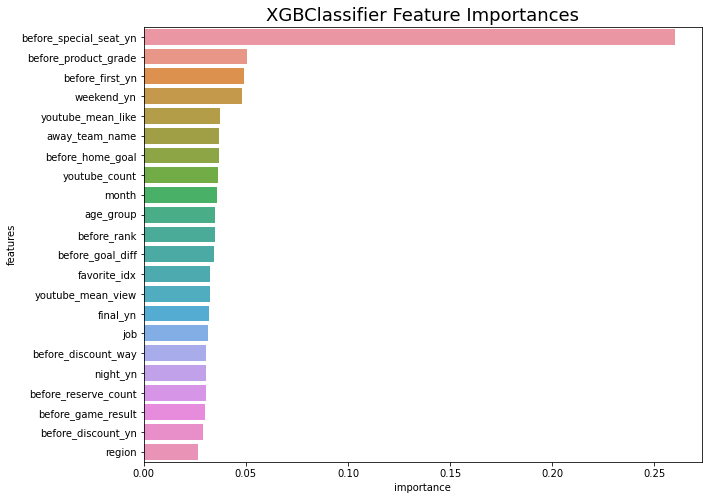

In [90]:
plt.figure(figsize=(10, 8))
sns.barplot(x='importance', y='features', data=feature_importance)
plt.title('XGBClassifier Feature Importances', fontsize=18)
plt.show()

In [91]:
df[['MB_IDX','date']] = raw[['MB_IDX','date']]

In [92]:
df.head()

,date,MB_IDX,before_product_grade,before_special_seat_yn,before_discount_yn,before_discount_way,before_first_yn,before_reserve_count,weekend_yn,night_yn,...,total_special_seat,total_reserve_date,total_reserve_ticket,rate_ticket_discount,rate_special_seat,mean_reserve_ticket,mean_game_nth_diff,last_game_nth,cluster,target
0,2022-02-26,122611,Exciting석,0,0,없음,1,1,1,0,...,0,5,9,0.11,0.00,1.80,3.75,16,3,0
1,2022-02-26,134139,Exciting석,0,0,없음,1,1,1,0,...,0,8,18,0.50,0.00,2.25,2.57,19,3,0
2,2022-02-26,136924,Exciting석,0,0,없음,1,1,1,0,...,0,9,13,0.00,0.00,1.44,2.00,17,3,0
3,2022-03-05,119758,Exciting석,0,0,없음,1,2,1,1,...,0,2,4,0.00,0.00,2.00,1.00,3,3,0
4,2022-03-05,132795,Exciting석,0,0,없음,1,3,1,1,...,6,4,13,0.00,0.46,3.25,5.67,19,2,0


In [93]:
df.to_csv('data_analysis2.csv', index=False)